In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

13:24:34 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-lfp-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [6]:
lfp_action = actions['stimulus-lfp-response']
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [7]:
lfp_results = pd.merge(sessions, lfp_results, how='left')

In [8]:
lfp_results = lfp_results.query('stim_location!="mecl" and stim_location!="mecr"')

In [9]:
def action_group(row):
    a = int(row.channel_group in [0,1,2,3])
    return f'{row.action}-{a}'
lfp_results['action_side_a'] = lfp_results.apply(action_group, axis=1)

In [10]:
lfp_results['stim_strength'] = lfp_results['stim_p_max'] / lfp_results['theta_energy']

In [11]:
lfp_results_hemisphere = lfp_results.sort_values(
    by=['action_side_a', 'stim_strength', 'signal_to_noise'], ascending=[True, False, False]
).drop_duplicates(subset='action_side_a', keep='first')
lfp_results_hemisphere.loc[:,['action_side_a','channel_group', 'signal_to_noise', 'stim_strength']].head()

,action_side_a,channel_group,signal_to_noise,stim_strength
68,1833-010719-1-0,4,0.006686,NaN
66,1833-010719-1-1,2,0.034550,NaN
694,1833-010719-2-0,6,0.004609,7.173297
691,1833-010719-2-1,3,0.003974,6.446883
580,1833-020719-1-0,4,0.008427,NaN


In [12]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and Hz11', 'frequency==11', 'baseline and Hz30', 'frequency==30']

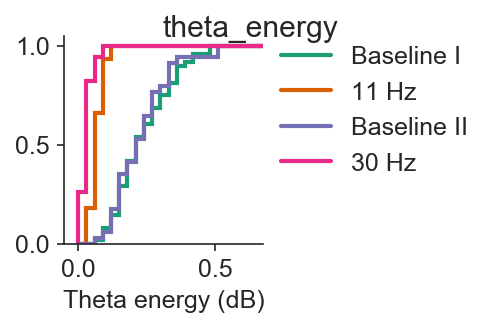

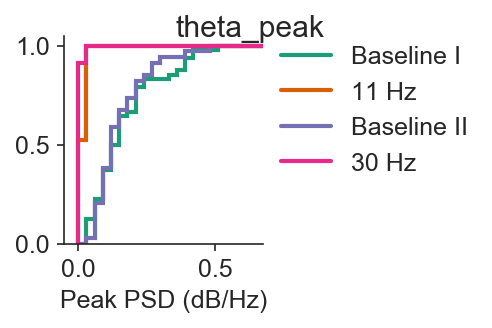

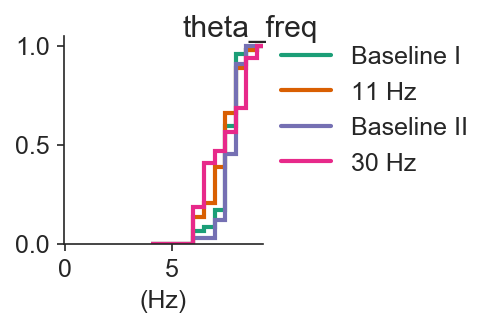

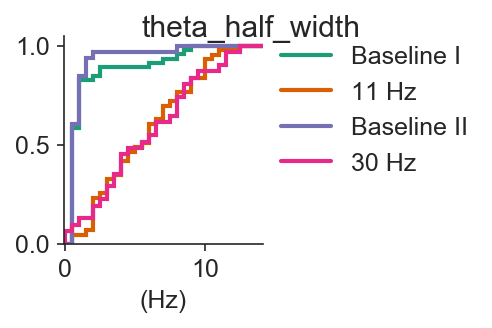

In [51]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': np.arange(0, .7, .03),
    'theta_peak': np.arange(0, .7, .03),
    'theta_freq': np.arange(4, 10, .5),
    'theta_half_width': np.arange(0, 15, .5)
}
xlabel = {
    'theta_energy': 'Theta energy (dB)',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}
# key = 'theta_energy'
# key = 'theta_peak'
results = {}
for key in bins:
    results[key] = pd.DataFrame()
    fig = plt.figure(figsize=(3.5,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors, queries, labels):
        values = lfp_results_hemisphere.query(query)[key]
        results[key] = pd.concat([results[key], values.rename(label).reset_index(drop=True)], axis=1)
        values.hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.025)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

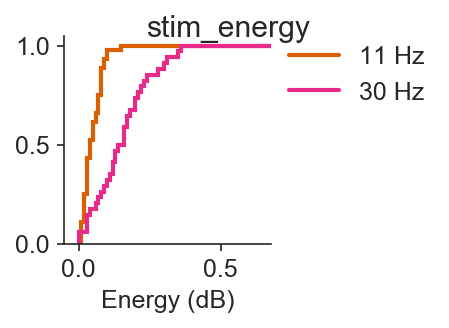

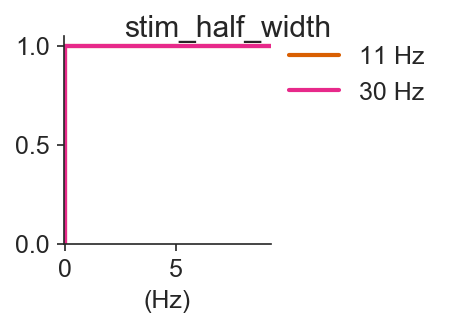

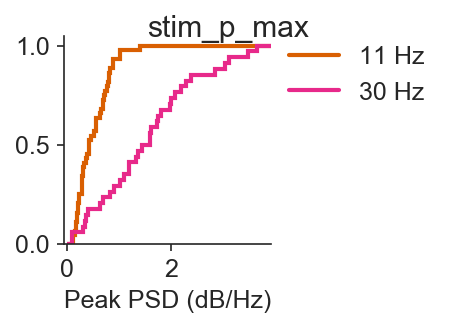

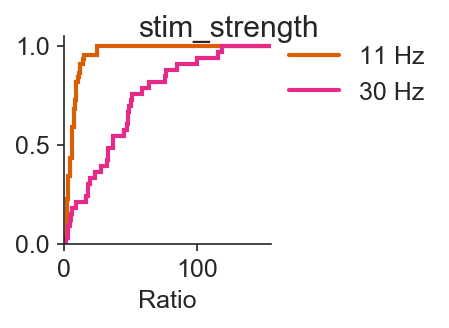

In [62]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .7, .01),
    'stim_half_width': np.arange(0, 10, .5),
    'stim_p_max': np.arange(0, 4, .01),
    'stim_strength': np.arange(0, 160, 1)
}
xlabel = {
    'stim_energy': 'Energy (dB)',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for key in bins:
    results[key] = pd.DataFrame()
    fig = plt.figure(figsize=(3.2,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
        values = lfp_results_hemisphere.query(query)[key]
        results[key] = pd.concat([results[key], values.rename(label).reset_index(drop=True)], axis=1)
        values.hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

In [64]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(df, keys):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [67]:


stat = pd.DataFrame()

for key, df in results.items():
    Key = rename(key)
    stat[Key] = df.agg(summarize)
    stat[Key] = df.agg(summarize)
    
    for i, c1 in enumerate(df.columns):
        for c2 in df.columns[i+1:]:
            stat.loc[f'MWU {c1} {c2}', Key] = MWU(df, [c1, c2])
            stat.loc[f'PRS {c1} {c2}', Key] = PRS(df, [c1, c2])

stat

,Theta energy,Theta peak,Theta freq,Theta half width,Stim energy,Stim half width,Stim p max,Stim strength
Baseline I,0.25 ± 0.02 (48),0.18 ± 0.02 (48),7.78 ± 0.09 (48),1.79 ± 0.33 (46),NaN,NaN,NaN,NaN
11 Hz,0.08 ± 0.00 (44),0.03 ± 0.00 (44),7.55 ± 0.12 (44),5.80 ± 0.50 (43),0.05 ± 0.00 (44),0.16 ± 0.00 (44),0.51 ± 0.04 (44),7.14 ± 0.81 (44)
Baseline II,0.24 ± 0.02 (34),0.17 ± 0.02 (34),7.96 ± 0.09 (34),1.23 ± 0.22 (33),NaN,NaN,NaN,NaN
30 Hz,0.04 ± 0.00 (34),0.02 ± 0.00 (34),7.74 ± 0.19 (34),5.88 ± 0.64 (31),0.16 ± 0.02 (34),0.14 ± 0.00 (34),1.54 ± 0.16 (34),45.30 ± 6.54 (34)
MWU Baseline I 11 Hz,"2075.00, 0.000","2102.00, 0.000","1201.50, 0.256","253.00, 0.000",NaN,NaN,NaN,NaN
PRS Baseline I 11 Hz,"0.15, 0.000","0.12, 0.000","0.05, 0.679","4.74, 0.000",NaN,NaN,NaN,NaN
MWU Baseline I Baseline II,"860.00, 0.682","850.00, 0.753","645.50, 0.108","805.00, 0.651",NaN,NaN,NaN,NaN
PRS Baseline I Baseline II,"0.00, 0.954","0.01, 0.612","0.30, 0.008","0.05, 0.582",NaN,NaN,NaN,NaN
MWU Baseline I 30 Hz,"1629.00, 0.000","1629.00, 0.000","781.50, 0.749","225.00, 0.000",NaN,NaN,NaN,NaN
PRS Baseline I 30 Hz,"0.19, 0.000","0.13, 0.000","0.20, 0.416","4.84, 0.000",NaN,NaN,NaN,NaN


In [68]:
stat.to_latex(output_path / "statistics" / "statistics.tex")
stat.to_latex(output_path / "statistics" / "statistics.csv")

# Plot PSD

In [15]:
psd = pd.read_feather(output_path / 'data' / 'psd.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [16]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [19]:
freq = freqs.T.iloc[0].values

mask = (freq < 49)

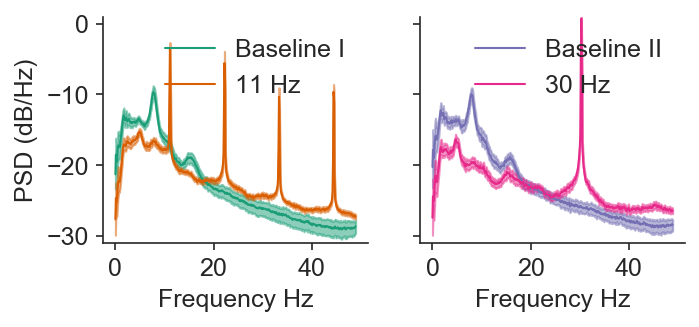

In [24]:

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
axs = axs.repeat(2)
for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
    selection = [
        f'{r.action}_{r.channel_group}' 
        for i, r in lfp_results_hemisphere.query(query).iterrows()]
    values = psd.loc[mask, selection].to_numpy()
    values = 10 * np.log10(values)
    plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#     ax.set_title(titles[i])
    ax.set_xlabel('Frequency Hz')
    ax.legend(frameon=False)
axs[0].set_ylabel('PSD (dB/Hz)')
axs[0].set_ylim(-31, 1)
despine()

figname = 'lfp-psd'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [69]:
action = project.require_action("stimulus-lfp-response")

In [70]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/data/psd.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/data/freqs.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figures/lfp-psd-histogram-stim_energy.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figures/lfp-psd-histogram-stim_strength.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figures/lfp-psd.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figures/lfp-psd-histogram-theta_peak.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figures/lfp-psd-histogram-stim_p_max.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response/data/figure

In [71]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-lfp-response.ipynb")